In [1]:
#Updated json_metadata.csv and 63x.csv on 7/12/2018

In [2]:
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

import post_patch as pp #post patch script
#post_patch_column = 'extraction.postPatch'
#post_patch_pipette_column = 'extraction.endPipetteR'

#sns.set_style('whitegrid') #Makes a white backround with gray horizontal gridmarks at y-values
sns.set_context('notebook')

In [3]:
def get_json_df():
    json_df = pd.read_csv('C:/users/ramr/documents/github/coding/personal-projects/csv/json_metadata.csv')
    json_df = json_df[json_df['status'] == 'SUCCESS']
    
    #Creates patch_duration column and outputs in minutes
    json_df['patch_duration'] = pd.to_datetime(json_df['extraction.timeRetractionEnd']) - pd.to_datetime(json_df['recording.timeWholeCellStart'])
    json_df['patch_duration'] = (json_df['patch_duration'].astype('timedelta64[s]'))/60
    
    json_df['date'] = json_df['date'].str[:10] #Strip away the time
    json_df['date'] = pd.to_datetime(json_df['date']) #Converting to YYYY-MM-DD    
    
    json_df = pp.postpatch_reclass(json_df) #Makes post patch column with the script
    
    json_df = json_df[['date', 'patch_duration', 'post_patch', 'extraction.tubeID']]
    return json_df

In [4]:
def get_morph_df():
    morph_df = pd.read_csv("C:/users/ramr/documents/github/coding/personal-projects/csv/63x.csv")
    morph_df = morph_df.loc[:,['patched_cell_container', 'ims63x_go_no_go']]
    return morph_df

In [5]:
def merge_dfs(df1, df2):
    merged_df = pd.merge(left = df1, 
                         right = df2, 
                         left_on = 'extraction.tubeID',
                         right_on = 'patched_cell_container',
                         how = 'inner')
    return merged_df

In [6]:
def sort_df(final_df):
    final_df = final_df.set_index('date') #Set date column as index column

    #Production Date Start = '2017-10-01' 
    start_date = '2017-10-01'
    final_df = final_df[start_date:] #Choosing start & end date    

    final_df.rename(columns = {'ims63x_go_no_go' : 'morph'}, inplace = True)
    final_df.drop(['extraction.tubeID', 'patched_cell_container'], axis=1, inplace=True)
    final_df.dropna(subset = ['morph'], inplace = True)

    #Categorical
    final_df['morph'] = final_df['morph'].astype('category')

    final_df.sort_index(inplace = True)     
    return final_df

In [7]:
#Making global variables
json_df = get_json_df()
morph_df = get_morph_df()
merged_df = merge_dfs(json_df, morph_df)
final_df = sort_df(merged_df)

C:\Users\ramr\AppData\Local\Continuum\anaconda2\lib\site-packages\pandas\core\indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\ramr\AppData\Local\Continuum\anaconda2\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [8]:
final_df.head()

,patch_duration,post_patch,morph
date,,,
2017-10-02,9.483333,Nuc-high seal,63x go
2017-10-02,12.250000,No-low seal,63x go
2017-10-02,9.216667,No-low seal,63x no go
2017-10-02,11.866667,No-low seal,63x no go
2017-10-02,9.633333,Nuc-high seal,63x go


In [9]:
final_df.tail()

,patch_duration,post_patch,morph
date,,,
2018-07-10,15.183333,No-low seal,63x go
2018-07-10,15.183333,No-low seal,63x go
2018-07-10,15.183333,No-low seal,63x go
2018-07-10,3.666667,No-low seal,63x go
2018-07-10,10.566667,No-low seal,63x go


[Text(0,0.5,u'Patch Duration (min)'), Text(0.5,0,u'Post Patch Outcomes')]

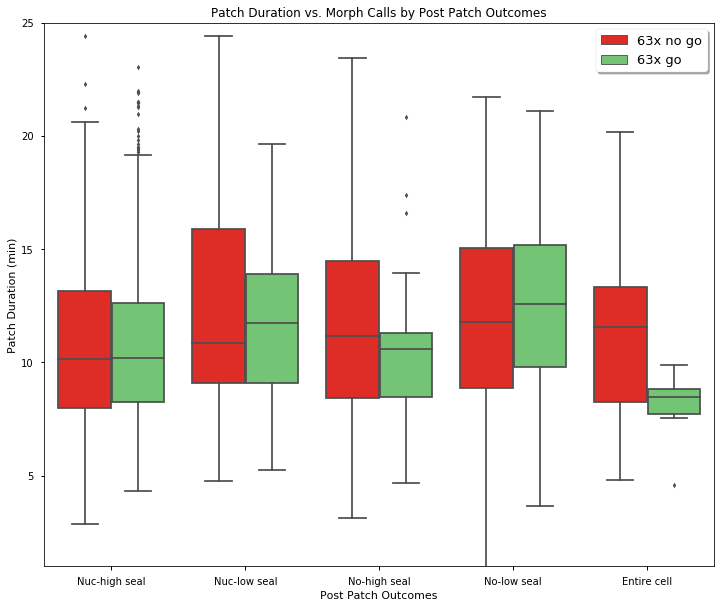

In [10]:
plt.subplots(figsize=(12,10)) #Has to be before the plot to work

bp = sns.boxplot(x = 'post_patch', y = 'patch_duration', hue = 'morph',
                 order = ['Nuc-high seal', 'Nuc-low seal', 'No-high seal', 'No-low seal','Entire cell'],
                 hue_order = ['63x no go','63x go'], data = final_df, palette = ['#de2d26', '#74c476'],
                 saturation = 1, fliersize = 4)

bp.legend(loc = 0, 
          #bbox_to_anchor = (0.95, 1), 
          frameon = True, 
          shadow = True,
          fontsize = 13)

bp.set(ylim=(1, 25))

bp.set_title('Patch Duration vs. Morph Calls by Post Patch Outcomes')
bp.set(xlabel = 'Post Patch Outcomes', ylabel = 'Patch Duration (min)')
#plt.savefig('Boxplot_PD_vs_M_by_PP')